#  Defining the RMT methods (Github)

In [ ]:
%%capture --no-display
!pip install yfinance
!pip install yahoofinancials
!pip install rie_estimator

from __future__ import division, print_function
from builtins import reversed
from builtins import map, zip
from collections.abc import MutableSequence, Sequence
import copy
from numpy import cov
import math
from math import ceil
from numbers import Complex, Integral, Real
import sys
import warnings
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf
import rie_estimator

import numpy as np
import matplotlib as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import datetime as dt
import pandas_datareader
from numpy import cov
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
def checkDesignMatrix(X):
    """
       Parameters
       ----------
       X: a matrix of shape (T, N), where T denotes the number
           of samples and N labels the number of features.
           If T < N, a warning is issued to the user, and the transpose
           of X is considered instead.
       Returns:
       T: type int
       N: type int
       transpose_flag: type bool
           Specify if the design matrix X should be transposed
           in view of having less rows than columns.
    """

    try:
        assert isinstance(X, (np.ndarray, pd.DataFrame, pd.Series,
                              MutableSequence, Sequence))
    except AssertionError:
        raise
        sys.exit(1)

    #to convert input to an array. Input can be lists, lists of tuples, tuples, tuples of tuples, tuples of lists and arrays.
    X = np.asarray(X, dtype=float)
    #Scalar and 1-dimensional inputs are converted to 2-dimensional arrays, whilst higher-dimensional inputs are preserved.
    X = np.atleast_2d(X)

    if X.shape[0] < X.shape[1]:
        warnings.warn("The Marcenko-Pastur distribution pertains to "
                      "the empirical covariance matrix of a random matrix X "
                      "of shape (T, N). It is assumed that the number of "
                      "samples T is assumed higher than the number of "
                      "features N. The transpose of the matrix X submitted "
                      "at input will be considered in the cleaning schemes "
                      "for the corresponding correlation matrix.", UserWarning)

        T, N = reversed(X.shape)
        transpose_flag = True
    else:
        T, N = X.shape
        transpose_flag = False

    return T, N, transpose_flag

def stieltjes(z, E):
    """
       Parameters
       ----------
       z: complex number
       E: square matrix
       Returns
       -------
       A complex number, the resolvent of square matrix E,
       also known as its Stieltjes transform.
       Reference
       ---------
       "Financial Applications of Random Matrix Theory: a short review",
       J.-P. Bouchaud and M. Potters
       arXiv: 0910.1205 [q-fin.ST]
    """

    try:
        assert isinstance(z, Complex)

        assert isinstance(E, (np.ndarray, pd.DataFrame,
                              MutableSequence, Sequence))
        E = np.asarray(E, dtype=float)
        E = np.atleast_2d(E)
        assert E.shape[0] == E.shape[1]
    except AssertionError:
        raise
        sys.exit(1)

    N = E.shape[0]

    ret = z * np.eye(N, dtype=float) - E
    ret = np.trace(ret) / N

    return ret


# Cleaning Using Clipped Function
def marcenkoPastur(X):
    """
       Parameter
       ---------
       X: random matrix of shape (T, N), with T denoting the number
           of samples, whereas N refers to the number of features.
           It is assumed that the variance of the elements of X
           has been normalized to unity.
       Returns
       -------
       (lambda_min, lambda_max): type tuple
           Bounds to the support of the Marcenko-Pastur distribution
           associated to random matrix X.
       rho: type function
           The Marcenko-Pastur density.
       Reference
       ---------
       "DISTRIBUTION OF EIGENVALUES FOR SOME SETS OF RANDOM MATRICES",
       V. A. Marcenko and L. A. Pastur
       Mathematics of the USSR-Sbornik, Vol. 1 (4), pp 457-483
    """

    T, N, _ = checkDesignMatrix(X)
    q = N / float(T)

    lambda_min = (1 - np.sqrt(q))**2
    lambda_max = (1 + np.sqrt(q))**2

    def rho(x):
        ret = np.sqrt((lambda_max - x) * (x - lambda_min))
        ret /= 2 * np.pi * q * x
        return ret if lambda_min < x < lambda_max else 0.0

    return (lambda_min, lambda_max), rho


def xiHelper(x, q, E):
    """Helper function to the rotationally-invariant, optimal shrinkage
       estimator of the true correlation matrix (implemented via function
       optimalShrinkage of the present module).
       Parameters
       ----------
       x: type derived from numbers.Real
           Would typically be expected to be an eigenvalue from the
           spectrum of correlation matrix E. The present function
           can however handle an arbitrary floating-point number.
       q: type derived from numbers.Real
           The number parametrizing a Marcenko-Pastur spectrum.
       E: type numpy.ndarray
           Symmetric correlation matrix associated with the
           Marcenko-Pastur parameter q specified above.
       Returns
       -------
       xi: type float
           Cleaned eigenvalue of the true correlation matrix C underlying
           the empirical correlation E (the latter being corrupted
           with in-sample noise). This cleaned version is computed
           assuming no prior knowledge on the structure of the true
           eigenvectors (thereby leaving the eigenvectors of E unscathed).
       References
       ----------
       * "Rotational invariant estimator for general noisy matrices",
         J. Bun, R. Allez, J.-P. Bouchaud and M. Potters
         arXiv: 1502.06736 [cond-mat.stat-mech]
       * "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
         J. Bun, J.-P. Bouchaud and M. Potters
         arXiv: 1610.08104 [cond-mat.stat-mech]
    """

    try:
        assert isinstance(x, Real)
        assert isinstance(q, Real)
        assert isinstance(E, np.ndarray) and E.shape[0] == E.shape[1]
        assert np.allclose(E.transpose(1, 0), E)
    except AssertionError:
        raise
        sys.exit(1)

    N = E.shape[0]

    z = x - 1j / np.sqrt(N)
    s = stieltjes(z, E)
    xi = x / abs(1 - q + q * z * s)**2

    return xi

def clipped(X, alpha=None, return_covariance=False):
    """Clips the eigenvalues of an empirical correlation matrix E
       in order to provide a cleaned estimator E_clipped of the
       underlying correlation matrix.
       Proceeds by keeping the [N * alpha] top eigenvalues and shrinking
       the remaining ones by a trace-preserving constant
       (i.e. Tr(E_clipped) = Tr(E)).
       Parameters
       ----------
       X: design matrix, of shape (T, N), where T denotes the number
           of samples (think measurements in a time series), while N
           stands for the number of features (think of stock tickers).
       alpha: type float or derived from numbers.Real (default: None)
           Parameter between 0 and 1, inclusive, determining the fraction
           to keep of the top eigenvalues of an empirical correlation matrix.
           If left unspecified, alpha is chosen so as to keep all the
           empirical eigenvalues greater than the upper limit of
           the support to the Marcenko-Pastur spectrum. Indeed, such
           eigenvalues can be considered as associated with some signal,
           whereas the ones falling inside the Marcenko-Pastur range
           should be considered as corrupted with noise and indistinguishable
           from the spectrum of the correlation of a random matrix.
           This ignores finite-size effects that make it possible
           for the eigenvalues to exceed the upper and lower edges
           defined by the Marcenko-Pastur spectrum (cf. a set of results
           revolving around the Tracy-Widom distribution)

       return_covariance: type bool (default: False)
           If set to True, compute the standard deviations of each individual
           feature across observations, clean the underlying matrix
           of pairwise correlations, then re-apply the standard
           deviations and return a cleaned variance-covariance matrix.
       Returns
       -------
       E_clipped: type numpy.ndarray, shape (N, N)
           Cleaned estimator of the true correlation matrix C underlying
           a noisy, in-sample estimate E (empirical correlation matrix
           estimated from X). This cleaned estimator proceeds through
           a simple eigenvalue clipping procedure (cf. reference below).

           If return_covariance=True, E_clipped corresponds to a cleaned
           variance-covariance matrix.
       Reference
       ---------
       "Financial Applications of Random Matrix Theory: a short review",
       J.-P. Bouchaud and M. Potters
       arXiv: 0910.1205 [q-fin.ST]
    """

    try:
        if alpha is not None:
            assert isinstance(alpha, Real) and 0 <= alpha <= 1

        assert isinstance(return_covariance, bool)
    except AssertionError:
        raise
        sys.exit(1)

    T, N, transpose_flag = checkDesignMatrix(X)
    if transpose_flag:
        X = X.T

    if not return_covariance:
        X = StandardScaler(with_mean=False,
                           with_std=True).fit_transform(X)

    ec = EmpiricalCovariance(store_precision=False,
                             assume_centered=True)
    ec.fit(X)
    E = ec.covariance_

    if return_covariance:
        inverse_std = 1./np.sqrt(np.diag(E))
        E *= inverse_std
        E *= inverse_std.reshape(-1, 1)

    eigvals, eigvecs = np.linalg.eigh(E)
    eigvecs = eigvecs.T

    if alpha is None:
        (lambda_min, lambda_max), _ = marcenkoPastur(X)
        xi_clipped = np.where(eigvals >= lambda_max, eigvals, np.nan)
    else:
        xi_clipped = np.full(N, np.nan)
        threshold = int(ceil(alpha * N))
        if threshold > 0:
            xi_clipped[-threshold:] = eigvals[-threshold:]

    gamma = float(E.trace() - np.nansum(xi_clipped))
    gamma /= np.isnan(xi_clipped).sum()
    xi_clipped = np.where(np.isnan(xi_clipped), gamma, xi_clipped)

    E_clipped = np.zeros((N, N), dtype=float)
    for xi, eigvec in zip(xi_clipped, eigvecs):
        eigvec = eigvec.reshape(-1, 1)
        E_clipped += xi * eigvec.dot(eigvec.T)

    tmp = 1./np.sqrt(np.diag(E_clipped))
    E_clipped *= tmp
    E_clipped *= tmp.reshape(-1, 1)

    if return_covariance:
      std = 1./inverse_std
      E_clipped *= std
      E_clipped *= std.reshape(-1, 1)

    return E_clipped

def linear_shrinkage(X, alpha=None, return_covariance=False):
          try:
              if alpha is not None:
                  assert isinstance(alpha, Real) and 0 <= alpha <= 1

              assert isinstance(return_covariance, bool)
          except AssertionError:
              raise
              sys.exit(1)

          T, N, transpose_flag = checkDesignMatrix(X)
          if transpose_flag:
              X = X.T

          if not return_covariance:
              X = StandardScaler(with_mean=False,
                                with_std=True).fit_transform(X)

          ec = LedoitWolf(assume_centered=False).fit(X)
          ec.fit(X)
          E = ec.covariance_
          return E

#linear_shrinkage(X,alpha=None, return_covariance=False)

# Part 1: Replicating Results: Dummy Try-out data
---
</br>

In [ ]:
# extracting the S&P500 data

#df = pandas_datareader.yahoo.daily.YahooDailyReader(symbols = ("TSLA", 'morningstar'), start='2000-01-01', end='2022-12-31')
#snp500 = yf.download('SPY', start='2000-01-01', end='2022-12-31')

In [ ]:
ticker_list=['DOW','AMZN','MSFT','TSLA','AAPL','IBM', 'GLD', 'XOM', 'TLT', 'SHY']

def getData(ticker):
    print (ticker)
    data = yf.download(ticker, start='2015-01-01', end='2022-12-31')
    data['ticker']=ticker
    return data

def getIndexData(ticker_list):
    snp_list=[]
    for ticker in ticker_list:
        snp_list.append(getData(ticker))

    index_data=pd.concat(snp_list)
    index_data.pop('Open')
    index_data.pop('High')
    index_data.pop('Low')
    index_data.pop('Adj Close')
    index_data.pop('Volume')

    # calculating the daily returns
    index_data['SMA'] = index_data['Close'].rolling(window=5).mean()
    index_data['Daily Returns'] = index_data['SMA'].pct_change()*100
    index_data = index_data.dropna()
    return index_data

In [ ]:
index_data=pd.concat(snp_list)
index_data.pop('Open')
index_data.pop('High')
index_data.pop('Low')
index_data.pop('Adj Close')
index_data.pop('Volume')

# calculating the daily returns
index_data['SMA'] = index_data['Close'].rolling(window=5).mean()
index_data['Daily Returns'] = index_data['SMA'].pct_change()*100
index_data = index_data.dropna()

NSE_pivot=pd.pivot_table(index_data, values = 'SMA', index=['Date'], columns = 'ticker').reset_index()
NSE_pivot=NSE_pivot.dropna()
NSE_pivot=NSE_pivot.reset_index(drop=True)
NSE_pivot.head()

In [ ]:
snp500 = getIndexData(ticker_list)
snp500.head()

DOW
[*********************100%***********************]  1 of 1 completed
AMZN
[*********************100%***********************]  1 of 1 completed
MSFT
[*********************100%***********************]  1 of 1 completed
TSLA
[*********************100%***********************]  1 of 1 completed
AAPL
[*********************100%***********************]  1 of 1 completed
IBM
[*********************100%***********************]  1 of 1 completed
GLD
[*********************100%***********************]  1 of 1 completed
XOM
[*********************100%***********************]  1 of 1 completed
TLT
[*********************100%***********************]  1 of 1 completed
SHY
[*********************100%***********************]  1 of 1 completed


,Close,ticker,SMA,Daily Returns
Date,,,,
2019-03-27,50.099998,DOW,49.135999,0.122259
2019-03-28,50.849998,DOW,49.509999,0.761152
2019-03-29,51.630001,DOW,50.116000,1.223996
2019-04-01,53.500000,DOW,50.985999,1.735972
2019-04-02,56.250000,DOW,52.466000,2.902758


In [ ]:
snp500_pivot=pd.pivot_table(snp500, values = 'SMA', index=['Date'], columns = 'ticker').reset_index()
snp500_pivot=snp500_pivot.dropna()
snp500_pivot=snp500_pivot.reset_index(drop=True)
snp500_pivot.head()

ticker,Date,AAPL,AMZN,DOW,GLD,IBM,MSFT,SHY,TLT,TSLA,XOM
0,2019-03-27,47.5070,89.077501,49.135999,124.104001,133.753348,117.922002,84.066000,124.792000,17.887600,80.698000
1,2019-03-28,47.1885,88.619101,49.509999,123.748001,133.462717,117.264001,84.122000,125.514000,17.948933,80.487999
2,2019-03-29,47.1335,88.778900,50.116000,123.356001,133.778204,117.442001,84.140001,125.830000,18.153334,80.551999
3,2019-04-01,47.2585,89.178201,50.985999,122.678001,134.565967,117.714000,84.090001,125.692001,18.536800,80.914000
4,2019-04-02,47.6200,89.480400,52.466000,122.214001,135.097516,117.970000,84.050002,125.618001,18.778267,80.998000


In [ ]:
snp500_pivot.describe()

ticker,AAPL,AMZN,DOW,GLD,IBM,MSFT,SHY,TLT,TSLA,XOM
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000
mean,114.764909,132.043056,52.956179,160.660869,128.152215,223.349076,84.944027,139.574391,167.616321,66.305863
std,41.003146,32.187161,8.980822,16.447455,9.714361,61.342077,1.648359,18.385051,114.449487,19.744514
min,44.114001,83.616000,24.880000,120.322002,95.512430,117.264001,80.662000,94.399998,12.412133,32.666000
25%,72.557499,95.946848,47.611500,150.933998,120.283460,165.763499,84.123500,130.631001,42.224267,51.499000
50%,125.958499,137.485750,53.111000,165.770999,128.997132,230.038002,85.251999,141.305998,199.510667,64.357998
75%,147.686498,161.945898,59.376501,171.752496,135.646267,271.640997,86.311501,151.537501,258.025665,79.625001
max,179.372000,185.432397,69.916000,191.157999,148.894003,340.567993,86.674001,170.740002,403.096667,113.484000


In [ ]:
'''
df1=snp500_pivot.copy()
df1=df1.drop(['Date','index'], axis=1)
df1[df1.columns]= df1[df1.columns].apply(np.log)
df1=df1.diff()
df1=df1.dropna()
scaler = StandardScaler()
df1[df1.columns] = StandardScaler().fit_transform(df1[df1.columns])
df1=df1.reset_index(drop=True)
'''

In [ ]:
'''
window=100
test_length = 5
train_length = 6
df1=df1.reset_index(drop=True)
df2 = df1.iloc[-1 - window:-test_length]
data_chunks=np.array_split(df2, len(df2)/train_length)
oracle_mean = []
for i,oracle_train in enumerate(data_chunks):
  X=np.array(oracle_train)
  corr_train = np.cov(X.T @ X)
  last_index = oracle_train.tail(1).index.item()
  oracle_test = df2.iloc[last_index+1:last_index+1+test_length]
  X1=np.array(oracle_test)
  corr_test = np.cov(X1.T @ X1)
  Lambda, U = np.linalg.eig(corr_train)
  inv_U = np.linalg.inv(U)
  lambda_oracle = np.dot(inv_U,np.dot(np.diag(Lambda),U))
  lambda_oracle = np.diag(lambda_oracle.diagonal())
  oracle_mean.append(lambda_oracle)
oracle_cov = (sum(oracle_mean))/len(data_chunks)
'''

'\nwindow=100\ntest_length = 5\ntrain_length = 6\ndf1=df1.reset_index(drop=True)\ndf2 = df1.iloc[-1 - window:-test_length]\ndata_chunks=np.array_split(df2, len(df2)/train_length)\noracle_mean = []\nfor i,oracle_train in enumerate(data_chunks):\n  X=np.array(oracle_train)\n  corr_train = np.cov(X.T @ X)\n  last_index = oracle_train.tail(1).index.item()\n  oracle_test = df2.iloc[last_index+1:last_index+1+test_length]\n  X1=np.array(oracle_test)\n  corr_test = np.cov(X1.T @ X1)\n  Lambda, U = np.linalg.eig(corr_train)\n  inv_U = np.linalg.inv(U)\n  lambda_oracle = np.dot(inv_U,np.dot(np.diag(Lambda),U))\n  lambda_oracle = np.diag(lambda_oracle.diagonal())\n  oracle_mean.append(lambda_oracle)\noracle_cov = (sum(oracle_mean))/len(data_chunks)\n'

In [ ]:
'''
from sklearn.model_selection import train_test_split

train, test = train_test_split(snp500, test_size=0.2)

def split_train_test(dataset, validation_size):
    valid = dataset.iloc[-validation_size:, :]
    train_test = dataset.iloc[:-validation_size)]

    train_length = int(0.63 * len(train_test))

    # split into input and outputs
    train_X, train_y = train_test.iloc[:train_length, :-1], train_test.iloc[:train_length, -1]
    test_X, test_y = train_test.iloc[train_length:, :-1], train_test.iloc[train_length:, -1]
    valid_X, valid_y = valid.iloc[:, :-1], valid.iloc[:, -1]

    return train_test, valid, train_X, train_y, test_X, test_y, valid_X, valid_y
'''

'\nfrom sklearn.model_selection import train_test_split\n\ntrain, test = train_test_split(snp500, test_size=0.2)\n\ndef split_train_test(dataset, validation_size):\n    valid = dataset.iloc[-validation_size:, :]\n    train_test = dataset.iloc[:-validation_size)]\n\n    train_length = int(0.63 * len(train_test))\n\n    # split into input and outputs\n    train_X, train_y = train_test.iloc[:train_length, :-1], train_test.iloc[:train_length, -1]\n    test_X, test_y = train_test.iloc[train_length:, :-1], train_test.iloc[train_length:, -1]\n    valid_X, valid_y = valid.iloc[:, :-1], valid.iloc[:, -1]\n\n    return train_test, valid, train_X, train_y, test_X, test_y, valid_X, valid_y\n'

In [ ]:
def oracle_ns(df,train_length,test_length,df_train_original):
  df1=df.copy()
  df1=df1.reset_index(drop=True)
  df2 = df1.iloc[:-test_length]
  data_chunks=np.array_split(df2, max(math.floor(len(df2)/train_length),1))
  oracle_mean = []
  for i,oracle_train in enumerate(data_chunks):
    last_index = oracle_train.tail(1).index.item()
    oracle_train.loc[:,oracle_train.columns] = StandardScaler().fit_transform(oracle_train.loc[:,oracle_train.columns])
    corr_train = np.array(oracle_train.astype(float).cov())
    #corr_train = np.cov(X.T @ X)/len(oracle_train)
    oracle_test = df1.iloc[last_index+1:last_index+1+test_length]
    #X1=np.array(oracle_test)
    oracle_test.loc[:,oracle_test.columns] = StandardScaler().fit_transform(oracle_test.loc[:,oracle_test.columns])
    corr_test = np.array(oracle_test.astype(float).cov())
    #corr_test = np.cov(X1.T @ X1)/len(oracle_test)
    Lambda, U = np.linalg.eig(corr_train)
    inv_U = np.linalg.inv(U)
    lambda_oracle = np.dot(inv_U,np.dot(corr_test,U))
    lambda_oracle = np.diag(lambda_oracle.diagonal())
    oracle_mean.append(lambda_oracle)
  oracle_cov = (sum(oracle_mean))/len(data_chunks)
  #X2=np.array(df_train_original)
  Lambda_train, U_train = np.linalg.eig(np.array(df_train_original.cov()))
  return np.dot(U_train,np.dot(oracle_cov,U_train.T))


In [ ]:
def RMT_methods(df):
  df1=df.copy()
  X=np.array(df1)
  RMT_clipped=clipped(X, alpha=None, return_covariance=True)
  #RMT_original = np.corrcoef(X.T @ X)
  ec = EmpiricalCovariance(store_precision=False,
                             assume_centered=True)
  ec.fit(X)
  RMT_original = ec.covariance_
  #RMT_oracle_ns = oracle_ns(df1,window,train_length,test_length,df1)

  #X_1 = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
  cov = LedoitWolf().fit(X)
  RMT_linear_shrikage=cov.covariance_
  RMT_identity = np.identity(len(df1.columns))
  RMT_rie = rie_estimator.get_rie(df1, normalize = False)
  return [RMT_rie, RMT_clipped, RMT_linear_shrikage,RMT_original ,RMT_identity]

In [ ]:
'''
df = snp500_pivot
oracle_window = 600
non_oracle_window = 365
df['Date'] = pd.DatetimeIndex(df['Date'])
df = df.sort_values(by = 'Date')
df['Year'] = df['Date'].dt.year
df_test=df[df['Year']==df['Year'].max()]
df_train=df[df['Year']!=df['Year'].max()]
train_length =60
test_length= 30
for i in range(0,len(df_test),1000):
    df_test_temp = df_test.iloc[0:i]
    df_test_final = df_test.iloc[i:]
    df_train_final=pd.concat([df_train,df_test_temp])
    df_train_final_oracle = data_preprocess(df_train_final.iloc[-1-oracle_window:])
    df_train_final_non_oracle = data_preprocess(df_train_final.iloc[-1-non_oracle_window:])
    df_test_final = data_preprocess(df_test_final)

    #RMT_oracle_nst = oracle_ns(df_train_final_oracle,train_length,test_length,df_train_final_non_oracle)
    '''

In [ ]:
'''
df1=df_train_final_oracle.copy()
df1=df1.reset_index(drop=True)
df2 = df1.iloc[:-test_length]
data_chunks=np.array_split(df2, max(math.floor(len(df2)/train_length),1))
oracle_mean = []
for i,oracle_train in enumerate(data_chunks):
  X=np.array(oracle_train)
  scaler = StandardScaler()
  oracle_train[oracle_train.columns] = StandardScaler().fit_transform(oracle_train[oracle_train.columns])
  corr_train = np.array(oracle_train.astype(float).corr())
  #corr_train = np.cov(X.T @ X)/len(oracle_train)
  last_index = oracle_train.tail(1).index.item()
  oracle_test = df1.iloc[last_index+1 : last_index+1+test_length]
  #X1=np.array(oracle_test)
  oracle_test[oracle_test.columns] = StandardScaler().fit_transform(oracle_test[oracle_test.columns])
  corr_test = np.array(oracle_test.astype(float).cov())
  print(corr_train)
  print(last_index+1+test_length)
  print("Breakpoint")
  print(corr_test)
  print("stop")
  #corr_test = np.cov(X1.T @ X1)/len(oracle_test)
  Lambda, U = np.linalg.eig(corr_train)
  inv_U = np.linalg.inv(U)
  lambda_oracle = np.dot(inv_U,np.dot(corr_test,U))
  lambda_oracle = np.diag(lambda_oracle.diagonal())
  oracle_mean.append(lambda_oracle)
oracle_cov = (sum(oracle_mean))/len(data_chunks)
X2=np.array(df_train_original)
Lambda_train, U_train = np.linalg.eig(np.cov(X2.T @ X2)/len(df_train_original))
'''

'\ndf1=df_train_final_oracle.copy()\ndf1=df1.reset_index(drop=True)\ndf2 = df1.iloc[:-test_length]\ndata_chunks=np.array_split(df2, max(math.floor(len(df2)/train_length),1))\noracle_mean = []\nfor i,oracle_train in enumerate(data_chunks):\n  X=np.array(oracle_train)\n  scaler = StandardScaler()\n  oracle_train[oracle_train.columns] = StandardScaler().fit_transform(oracle_train[oracle_train.columns])\n  corr_train = np.array(oracle_train.astype(float).corr())\n  #corr_train = np.cov(X.T @ X)/len(oracle_train)\n  last_index = oracle_train.tail(1).index.item()\n  oracle_test = df1.iloc[last_index+1 : last_index+1+test_length]\n  #X1=np.array(oracle_test)\n  oracle_test[oracle_test.columns] = StandardScaler().fit_transform(oracle_test[oracle_test.columns])\n  corr_test = np.array(oracle_test.astype(float).cov())\n  print(corr_train)\n  print(last_index+1+test_length)\n  print("Breakpoint")\n  print(corr_test)\n  print("stop")\n  #corr_test = np.cov(X1.T @ X1)/len(oracle_test)\n  Lambda, U 

In [ ]:
def data_preprocess(df):
  df1=df.copy()
  df1=df1.drop(['Date','Year'], axis=1)
  df1[df1.columns]= df1[df1.columns].apply(np.log)
  df1=df1.diff()
  df1=df1.dropna()
  new=df1.apply(lambda num: num**2)
  df1['vol']=new.sum(axis=1)
  df1['vol']=np.sqrt(df1['vol'])
  df1.iloc[:,:-1] = df1.iloc[:,:-1].div(df1.vol, axis=0)
  df1=df1.drop(['vol'], axis=1)
  scaler = StandardScaler()
  df1.loc[:,df1.columns] = StandardScaler().fit_transform(df1.loc[:,df1.columns])
  return df1

def portfolio_result(df,non_oracle_window,oracle_window,train_length,test_length,Method_names):
      df['Date'] = pd.DatetimeIndex(df['Date'])
      df = df.sort_values(by = 'Date')
      df['Year'] = df['Date'].dt.year
      df_test=df[df['Year']==df['Year'].max()]
      df_train=df[df['Year']!=df['Year'].max()]
      for i in range(0,len(df_test),len(df_test)+1):
          df_test_temp = df_test.iloc[0:i]
          df_test_final = df_test.iloc[i:]
          df_train_final=pd.concat([df_train,df_test_temp])

          df_train_final_oracle = data_preprocess(df_train_final.iloc[-1-oracle_window:])
          df_train_final_non_oracle = data_preprocess(df_train_final.iloc[-1-non_oracle_window:])
          df_test_final = data_preprocess(df_test_final)
          cov_list=RMT_methods(df_train_final_non_oracle)
          RMT_oracle_nst = oracle_ns(df_train_final_oracle,train_length,test_length,df_train_final_non_oracle)
          RMT_oracle_st = oracle_ns(df_train_final_oracle,len(df_train_final_oracle)-len(df_test_final),len(df_test_final),df_train_final_non_oracle)
          cov_list.append(RMT_oracle_nst)
          cov_list.append(RMT_oracle_st)
          '''
          df_return = df_train_final.pct_change(periods=63)
          df_return = df_return.values[-1:]
          '''
          # Minimum variance portfolio- returns equally weighted
          n_assets = len(df_test_final.columns)
          s = (1,n_assets)
          df_return = np.ones(s)
          portfolio_return = (np.array(df_return).T)
          methods_var = []
          methods_return = []
          for j in range(0,len(cov_list)):
            print(' ')
            print(Method_names[j])
            weights = markowitz_weight(portfolio_return,cov_list[j])
            weights = weights/sum(weights)
            port_ret,port_ret_list = outofsample_returns(weights,df_test_final)
            port_risk, port_risk_list = outofsample_risk(weights,df_test_final)
            methods_return.append(port_ret_list)
            methods_var.append(port_risk_list)
            sharpe_ratio = port_ret/np.sqrt(port_risk)
            annual_return = fullperiod_returns(weights,df_test_final)
            print("The daily average return:",port_ret)
            print("The daily average risk:",port_risk)
            print("The Sharpe Ratio:",sharpe_ratio)
            print("The Annual_return:",annual_return)
      return methods_return,methods_var,df_test


def outofsample_risk(weights,data):
  ans = 0
  var_list = []
  for i in range(0,len(data)):
      temp = np.array(data.iloc[i:i+1])
      var = np.square(np.dot(temp,weights)[0][0])
      var_list.append(var)
      ans += np.square(np.dot(temp,weights)[0][0])
  return ans/len(data),var_list

def outofsample_returns(weights,df):
  ans = 0
  mean_list = []
  for i in range(0,len(df)):
      temp = np.array(df.iloc[i:i+1])
      mean = np.dot(temp,weights)[0][0]
      mean_list.append(mean)
      ans += np.dot(temp,weights)[0][0]
  return ans/len(df),mean_list

def fullperiod_returns(weights,df):
  ans = 0
  df1=df.sum(axis = 0, skipna = True)
  temp=np.array(pd.DataFrame(df1).T)
  ans = np.dot(temp,weights)[0][0]
  return ans

def markowitz_weight(portfolio_return,cov_mat):
      num = np.dot(np.linalg.inv(cov_mat),portfolio_return)
      dem = np.dot(portfolio_return.T,num)
      ans = num/dem[0][0]
      return ans

In [ ]:
Method_names =  ["RMT_rie", "RMT_clipped", "RMT_linear_shrikage","RMT_original" ,"RMT_identity","RMT_Oracle_NonStationary","RMT_Oracle_Stationary"]
port_ret,port_risk,df_test =portfolio_result(snp500_pivot,365,700,90,30,Method_names)

 
RMT_rie
The daily average return: -2.176037128265307e-17
The daily average risk: 0.2622358237665411
The Sharpe Ratio: -4.2493283542095285e-17
The Annual_return: -3.8858324335679696e-15
 
RMT_clipped
The daily average return: -3.663735981263017e-17
The daily average risk: 0.269434547255392
The Sharpe Ratio: -7.058258004086332e-17
The Annual_return: -4.653869452792893e-15
 
RMT_linear_shrikage
The daily average return: -3.241851231905457e-17
The daily average risk: 0.2599282646927412
The Sharpe Ratio: -6.358670598050977e-17
The Annual_return: -3.5369963946039697e-15
 
RMT_original
The daily average return: -1.0658141036401503e-17
The daily average risk: 0.2600440291594061
The Sharpe Ratio: -2.0900564671747962e-17
The Annual_return: -3.505359288709646e-15
 
RMT_identity
The daily average return: -1.5876189252139737e-17
The daily average risk: 0.27875044013300126
The Sharpe Ratio: -3.007035023097844e-17
The Annual_return: -2.8865798640254078e-15
 
RMT_Oracle_NonStationary
The daily avera

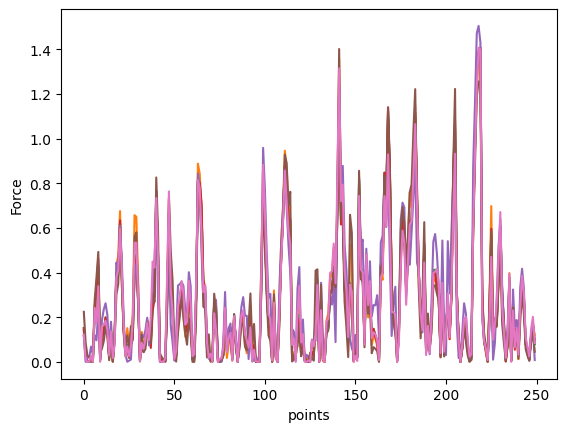

In [ ]:
 import matplotlib.pyplot as plt
 for impacts in port_risk:
     timefilteredForce = plt.plot(impacts)
     timefilteredForce = plt.xlabel('points')
     timefilteredForce = plt.ylabel('Force')

 plt.show()

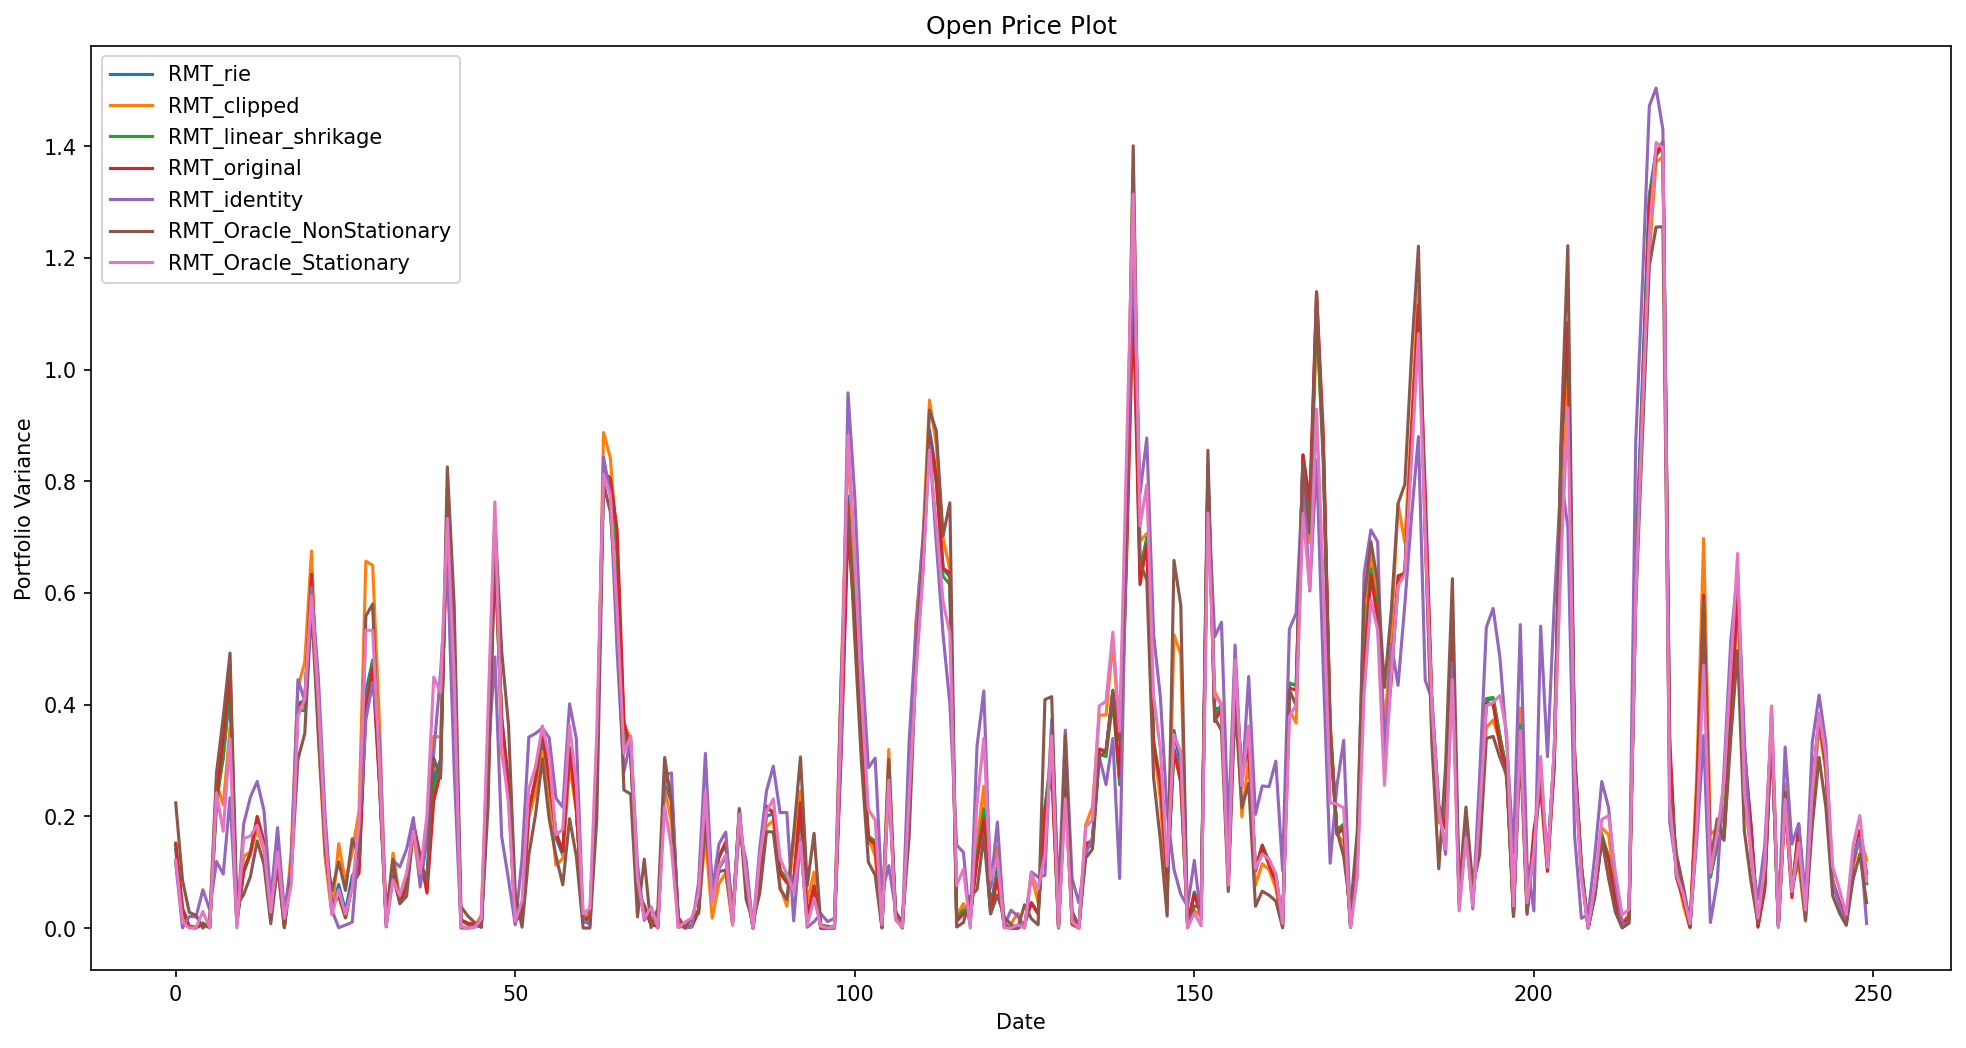

In [ ]:
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
for i,port_var in enumerate(port_risk):
     plt.plot(port_var,label=Method_names[i])

plt.xlabel('Date')
plt.ylabel('Portfolio Variance')

# adding title to the plot
plt.title('Open Price Plot')

# adding legend to the curve
plt.legend()
plt.show(x=df_test[])

# Replicating Results: Importing 500 stocks

In [ ]:
!pip install -q kaggle

In [ ]:
!pip install nsepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#create kaggle directory
!mkdir ~/.kaggle

In [ ]:
#copy json file to kaggle folder
! cp kaggle.json ~/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
#permiissonn for json to act
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d rohanrao/nifty50-stock-market-data

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! unzip /content/nifty50-stock-market-data.zip

Archive:  /content/nifty50-stock-market-data.zip.zip
  inflating: ADANIPORTS.csv          
  inflating: ASIANPAINT.csv          
  inflating: AXISBANK.csv            
  inflating: BAJAJ-AUTO.csv          
  inflating: BAJAJFINSV.csv          
  inflating: BAJFINANCE.csv          
  inflating: BHARTIARTL.csv          
  inflating: BPCL.csv                
  inflating: BRITANNIA.csv           
  inflating: CIPLA.csv               
  inflating: COALINDIA.csv           
  inflating: DRREDDY.csv             
  inflating: EICHERMOT.csv           
  inflating: GAIL.csv                
  inflating: GRASIM.csv              
  inflating: HCLTECH.csv             
  inflating: HDFC.csv                
  inflating: HDFCBANK.csv            
  inflating: HEROMOTOCO.csv          
  inflating: HINDALCO.csv            
  inflating: HINDUNILVR.csv          
  inflating: ICICIBANK.csv           
  inflating: INDUSINDBK.csv          
  inflating: INFRATEL.csv            
  inflating: INFY.csv              

In [ ]:
'''import os
import csv

dirpath = '/content'
output = 'output_file.csv'
with open(output, 'w') as outfile:
    csvout = csv.writer(outfile)
    csvout.writerow(['FileName', 'Content'])

    files = os.listdir(dirpath)

    for filename in files:
        with open(dirpath + '/' + filename) as afile:
            csvout.writerow([filename, afile.read()])
            afile.close()

    outfile.close()'''

"import os\nimport csv\n\ndirpath = '/content'\noutput = 'output_file.csv'\nwith open(output, 'w') as outfile:\n    csvout = csv.writer(outfile)\n    csvout.writerow(['FileName', 'Content'])\n\n    files = os.listdir(dirpath)\n\n    for filename in files:\n        with open(dirpath + '/' + filename) as afile:\n            csvout.writerow([filename, afile.read()])\n            afile.close()\n\n    outfile.close()"

In [ ]:
import pandas as pd
import glob
import os
path = r'/content/' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

#frame = pd.concat(li, axis=0, ignore_index=True)

print(df)

            Date Symbol Series  Prev Close     Open     High      Low  \
0     2000-01-03  CIPLA     EQ     1349.40  1410.00  1457.35  1380.05   
1     2000-01-04  CIPLA     EQ     1457.35  1537.00  1537.00  1430.00   
2     2000-01-05  CIPLA     EQ     1465.25  1474.00  1474.00  1365.00   
3     2000-01-06  CIPLA     EQ     1435.05  1434.00  1435.00  1349.00   
4     2000-01-07  CIPLA     EQ     1355.85  1370.00  1389.90  1247.40   
...          ...    ...    ...         ...      ...      ...      ...   
5301  2021-04-26  CIPLA     EQ      935.60   935.60   940.00   902.15   
5302  2021-04-27  CIPLA     EQ      905.40   913.00   919.50   901.00   
5303  2021-04-28  CIPLA     EQ      912.40   914.35   918.00   902.95   
5304  2021-04-29  CIPLA     EQ      910.20   911.95   917.40   904.00   
5305  2021-04-30  CIPLA     EQ      906.50   900.75   921.00   900.75   

         Last    Close     VWAP    Volume      Turnover    Trades  \
0     1457.35  1457.35  1441.36     21060  3.035496e+1

In [ ]:
#dropped columns one by one and overwrote to column name
df=df.drop(['%Deliverble'],axis=1)
print(df.head())

         Date Symbol Series  Prev Close    Open     High      Low     Last  \
0  2000-01-03  CIPLA     EQ     1349.40  1410.0  1457.35  1380.05  1457.35   
1  2000-01-04  CIPLA     EQ     1457.35  1537.0  1537.00  1430.00  1466.05   
2  2000-01-05  CIPLA     EQ     1465.25  1474.0  1474.00  1365.00  1441.00   
3  2000-01-06  CIPLA     EQ     1435.05  1434.0  1435.00  1349.00  1365.00   
4  2000-01-07  CIPLA     EQ     1355.85  1370.0  1389.90  1247.40  1247.40   

     Close     VWAP  Volume      Turnover  Trades  Deliverable Volume  
0  1457.35  1441.36   21060  3.035496e+12     NaN                 NaN  
1  1465.25  1460.43   30215  4.412698e+12     NaN                 NaN  
2  1435.05  1428.11   33799  4.826872e+12     NaN                 NaN  
3  1355.85  1390.55   33083  4.600356e+12     NaN                 NaN  
4  1247.55  1267.49   66536  8.433351e+12     NaN                 NaN  


In [ ]:
index_data=pd.concat(li)
index_data.pop('Open')
index_data.pop('High')
index_data.pop('Low')
index_data.pop('Last')
index_data.pop('VWAP')
index_data.pop('Turnover')
index_data.pop('Trades')
index_data.pop('Deliverable Volume')
index_data.pop('Volume')

# calculating the daily returns
index_data['SMA'] = index_data['Close'].rolling(window=5).mean()
index_data['Daily Returns'] = index_data['SMA'].pct_change()*100
#index_data = index_data.dropna()

NSE_pivot=pd.pivot_table(index_data, values = 'SMA', index=['Date'], columns = 'Symbol').reset_index()
#NSE_pivot=NSE_pivot.dropna()
NSE_pivot=NSE_pivot.reset_index(drop=True)
NSE_pivot.head()

Symbol,Date,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJAUTOFIN,BAJFINANCE,BHARTI,BHARTIARTL,...,TISCO,TITAN,ULTRACEMCO,UNIPHOS,UPL,UTIBANK,VEDL,WIPRO,ZEEL,ZEETELE
0,2000-01-03,NaN,657.750,NaN,NaN,NaN,6824.935,NaN,NaN,NaN,...,408.965,635.155,NaN,NaN,NaN,1580.735,NaN,1599.570,NaN,675.890
1,2000-01-04,NaN,589.990,NaN,NaN,NaN,5192.740,NaN,NaN,NaN,...,345.050,514.280,NaN,NaN,NaN,1193.820,NaN,1925.680,NaN,819.640
2,2000-01-05,NaN,521.150,NaN,NaN,NaN,3516.650,NaN,NaN,NaN,...,281.430,389.790,NaN,NaN,NaN,802.025,NaN,2258.655,NaN,943.885
3,2000-01-06,NaN,450.035,NaN,NaN,NaN,1769.800,NaN,NaN,NaN,...,220.440,267.915,NaN,NaN,NaN,410.235,NaN,2578.840,NaN,1055.845
4,2000-01-07,NaN,382.680,NaN,NaN,NaN,46.320,NaN,NaN,NaN,...,160.000,147.470,NaN,NaN,NaN,26.120,NaN,2857.280,NaN,1151.770


In [ ]:
NSE_pivot

Symbol,Date,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJAUTOFIN,BAJFINANCE,BHARTI,BHARTIARTL,...,TISCO,TITAN,ULTRACEMCO,UNIPHOS,UPL,UTIBANK,VEDL,WIPRO,ZEEL,ZEETELE
0,2000-01-03,NaN,657.750,NaN,NaN,NaN,6824.935,NaN,NaN,NaN,...,408.965,635.155,NaN,NaN,NaN,1580.735,NaN,1599.570,NaN,675.890
1,2000-01-04,NaN,589.990,NaN,NaN,NaN,5192.740,NaN,NaN,NaN,...,345.050,514.280,NaN,NaN,NaN,1193.820,NaN,1925.680,NaN,819.640
2,2000-01-05,NaN,521.150,NaN,NaN,NaN,3516.650,NaN,NaN,NaN,...,281.430,389.790,NaN,NaN,NaN,802.025,NaN,2258.655,NaN,943.885
3,2000-01-06,NaN,450.035,NaN,NaN,NaN,1769.800,NaN,NaN,NaN,...,220.440,267.915,NaN,NaN,NaN,410.235,NaN,2578.840,NaN,1055.845
4,2000-01-07,NaN,382.680,NaN,NaN,NaN,46.320,NaN,NaN,NaN,...,160.000,147.470,NaN,NaN,NaN,26.120,NaN,2857.280,NaN,1151.770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,727.06,2542.530,666.08,3641.84,9812.31,NaN,4637.26,NaN,527.53,...,NaN,1492.750,6229.34,NaN,591.37,NaN,229.06,477.100,190.89,NaN
5302,2021-04-27,732.70,2543.020,676.36,3695.83,9936.60,NaN,4714.35,NaN,529.10,...,NaN,1488.030,6192.75,NaN,591.37,NaN,232.12,479.560,190.45,NaN
5303,2021-04-28,737.86,2555.200,687.64,3753.60,10070.58,NaN,4847.80,NaN,531.92,...,NaN,1485.220,6224.74,NaN,594.63,NaN,235.68,483.400,188.79,NaN
5304,2021-04-29,739.65,2575.640,699.78,3784.61,10335.12,NaN,5007.03,NaN,533.92,...,NaN,1490.410,6282.77,NaN,599.47,NaN,241.39,484.040,187.64,NaN


In [ ]:
# calculating ita(RIE) and coparing it with the eigen values of the cleaned covariance matrix





# dividing total length of time series T_tot into n consecutive non-overlapping samples of length T_out



# def R_2(t, w):
#     """
#     out of sample variance of returns
#     """
#     temp_1 = 0
#     temp_2 = 0
#     for j in range(T_out):

#         for i in range(N):

#             temp_1 += (w_i[i] * X_i_t[i][j])

#         temp_2 += (temp_1**2)
#     return temp_2/T_out

# temp_3 = 0

# for j in range(N):
#     temp_3 += R_2(t_j, u_i)
#     ita_ora += temp_3


In [ ]:
def markowitz_weight(df,n_assets):
      df = df.sort_values(by = 'Date')
      df['Year'] = df['Date'].year
      df_test=df[df['Year']==df['Year'].max()]
      df_train=df[df['Year']!=df['Year'].max()]
      for i in range(0,df_test.size(),126):
          df_test_temp = df.iloc[0:i]
          df_test_final = df_train_final.iloc[i:]
          df_train_final=df_train,df_test_temp
          df_train_final = data_preprocess(df_train_final)
          df_test_final = data_preprocess(df_test_final)
          cov_list=covariance_calc(df_train_final)
          df2 = df_train_final.drop(['Date','index'], axis=1).pct_change(periods=63)
          df2=df2.values[-1:]
          portfolio_return=(np.array(df2).T)/math.sqrt(n_assets)


          weights = markowitz_weight(portfolio_return,cov_list[i])
          weights = weights/sum(weights)
          port_ret=outofsample_returns(weights,df_test_final,)
          port_risk=outofsample_risk(weights,df_test_final,5)
          sharpe_ratio = port_ret/np.sqrt(port_risk)
          for i in range


def outofsample_risk(weights,df):
  df[df.columns]= df[df.columns].apply(np.log)
  df=df.diff()
  df=df.dropna()
  ans = 0
  for i in range(0,len(df)):
      temp = np.array(df.iloc[i:i+1])
      ans += np.square(np.dot(weights,temp)[0])
  return ans/len(df)

def outofsample_returns(weights,df):
  df[df.columns]= df[df.columns].apply(np.log)
  df=df.diff()
  df=df.dropna()
  ans = 0
  for i in range(0,len(df)):
      temp = np.array(df.iloc[i:i+1])
      ans += np.dot(weights,temp)[0]
  return ans/len(df)



def markowitz_weight(portfolio_return,cov_mat):
      num = np.dot(np.linalg.inv(cov_mat),portfolio_return)
      dem = np.dot(portfolio_return.T,num)
      return num/dem

SyntaxError: ignored

In [ ]:
def sharpe_ratio(rets, rfr, N):
    """
    Computes the annualized sharpe ratio for a set of returns

    Arguments:
        rets - return data
        rfr  - annualized risk-free rate
        N    - No. of periods per year (for example: N = 12 for a monthly return data)
    """
    # risk-free rate(per period) = [(1 + risk-free rate(annual))^(1 / no. of periods)] - 1
    rf_per_period= (1+ rfr)**(1/N)-1

    excess_return = rets - rf_per_period

    # calculating the annualized excess return using the method defined above
    ann_excess_return = annualize_rets(excess_return, N)

    # calculating the annualized volatility using the method defined above
    ann_vol = annualize_vol(excess_return, N)

    return ann_excess_return/ann_vol

#-----------------------------------

def annualize_rets(rets, N):
    """
    Annualizes a set of returns (rets)

    Arguments:
        rets - return data (DataFrame)
        N    - No. of periods per year (for example: N = 12 for a monthly return data)
    """
    compounded_growth = (1+rets).prod()
    # compounded growth = (1 + ret_1), (1 + ret_2), ....... , (1 + ret_n)
    n = rets.shape[0]

    # annualized return = (compounded growth)**(1/n)   ----->   if the returns entered are annual returns,     i.e. No. of periods = 1
    # annualized return = (compounded growth)**(N/n)   ----->   if the returns entered have          --->           No. of periods per year = N
    return compounded_growth**(N/n)-1

#-----------------------------------

def annualize_vol(rets, N):
    """
    Annualizes the volatility (vol) for a set of returns

    Arguments:
        rets - return data
        N    - No. of periods per year (for example: N = 12 for a monthly return data)
    """
    return rets.std() * (N ** 0.5)

#-----------------------------------

def portfolio_return(weights, rets):
    """
    Computes the return of a portfolio based on the returns and the weights of the constituents

    Arguments:
        weights - weight vector (a numpy array or Nx1 matrix)
        rets    - return data   (a numpy array or Nx1 matrix)
    """

    # weights.T          -->    weight vector transpose
    # weights.T @ rets   -->    Dot product of the weight vector transpose and the return vector
    return weights.T @ rets

#--------------------

def portfolio_vol(weights, covariance_matrix):
    """
    Computes the volatility of a portfolio from a covariance matrix and constituents' weights

    Arguments:
        weights           - weight vector     (a numpy array or Nx1 matrix)
        covariance_matrix - covariance matrix (an N x N matrix)
    """

    # weights.T          -->    weight vector transpose
    #
    # 2-security portfolio variance = (w_1 * sigma_1)^2 + (w_2 * sigma)^2 + 2(w_1 * w_2 * cov(1,2))   ---->   where, sigma = variance ^ 0.5
    #
    # N-security portfolio variance = (weights.T @ covariance_matrix @ weights)
    return (weights.T @ covariance_matrix @ weights)**0.5

In [ ]:
def train_test_split(df):
    df['year'] = df.index.year
    df = df.reset_index()
    df=df.sort_values('Date')
    year_list=list(df['year'].unique())
    year_list.sort()
    last_year = year_list[-1]
    train = df[df["year"] < last_year]
    test = df[df["year"] >= last_year]
    return train,test

train, test = train_test_split(snp500)
train['year'].unique()